In [12]:
import numpy
import h5py
import pandas as pd
import pennylane as qml
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from pennylane import numpy as np

In [2]:
events = np.load('10k_dijet_bb1.npy', requires_grad=False)
classes = np.load('10k_dijet_bb1_class.npy', requires_grad=False)
scaler = MinMaxScaler(feature_range=(0, sp.pi))
events = scaler.fit_transform(events)

In [25]:
f = open('events_LHCO2020_BlackBox1.masterkey', 'r')
event_classes = numpy.genfromtxt(f, delimiter=',')
print(event_classes.shape)
event_class = event_classes[classes.tolist()]

print(np.amax(event_classes))
print(np.amin(event_classes))

(1000000,)
1.0
0.0


In [4]:
n_shots = 5000
dev1 = qml.device('default.qubit', wires=6, shots=n_shots)

@qml.qnode(dev1)
def circuit(params, event=None):
    qml.broadcast(qml.RX, wires=[0, 1, 2], pattern='single', parameters=event)

    qml.broadcast(qml.RY, wires=[0, 1, 2], pattern='single', parameters=params)
    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern='all_to_all')
    
    qml.Hadamard(wires=5)
    qml.broadcast(qml.CSWAP, wires=[5, 1, 2, 3, 4], pattern=[[5, 1, 3], [5, 2, 4]])
    qml.Hadamard(wires=5)

    qml.PauliX(wires=5)
    
    return qml.expval(qml.PauliZ(wires=5))

[ 0.44561076  0.00715541 -0.00968506]


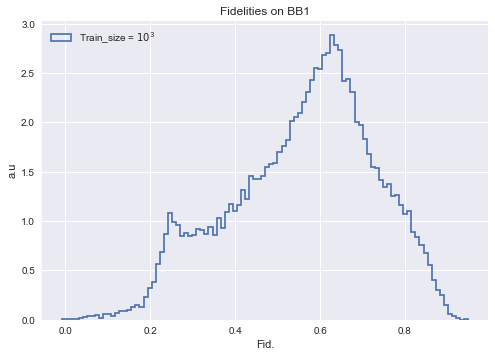

In [16]:
# fid = [None, None, None, None, None]
# plt.style.use("seaborn")
# plt.xlabel('Fid.')
# plt.ylabel('a.u')
# plt.legend(loc='upper left')
# plt.title('Fidelities on BB1')
# # plt.ion()
# for j in range(5):
#     tktheta = np.load('cont_best1e+0%d_data_theta.npy' % j)
#     print(tktheta)
#     cost = []

#     for i in range(np.size(events, axis=0)):
#         cost.append(circuit(tktheta, event=events[i, :]))

#     fid[j] = 1 - np.array(cost)
#     plt.hist(fid[j], bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{%d}$' % j)
#     plt.show()
    
# plt.savefig("cont_fid_hist_bb1.pdf")

plt.style.use("seaborn")
plt.xlabel('Fid.')
plt.ylabel('a.u')
plt.title('Fidelities on BB1')
tktheta = np.load('best1e+03_data_theta.npy')
print(tktheta)
cost = []

for i in range(np.size(events, axis=0)):
    cost.append(circuit(tktheta, event=events[i, :]))

fid = -1 * np.array(cost)
plt.hist(fid, bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{3}$')
plt.legend(loc='upper left')
    
plt.savefig("cont_fid_hist_bb1.pdf")

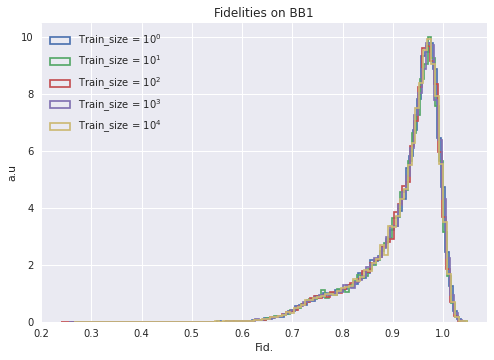

In [14]:
plt.style.use("seaborn")
plt.xlabel('Fid.')
plt.ylabel('a.u')
plt.title('Fidelities on BB1')
for j in range(5):
    plt.hist(fid[j], bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{%d}$' % j)
    plt.legend(loc='upper left')
    
plt.savefig("cont_fid_hist_bb1.pdf")

[ 0.44561076  0.00715541 -0.00968506]


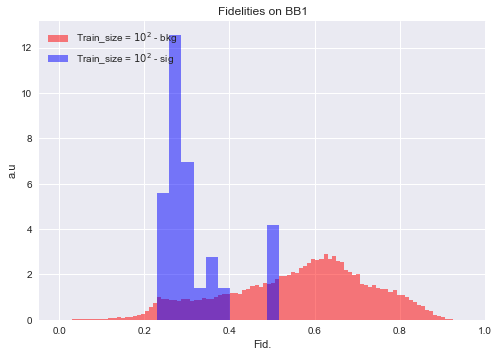

In [17]:
fid_split = [None, None]
tktheta = np.load('best1e+0%d_data_theta.npy' % 3)
print(tktheta)
bkg_cost, sig_cost = [], []
sig_event_count = 0

for i in range(np.size(events, axis=0)):
    if event_class[i] == 0:
        bkg_cost.append(circuit(tktheta, event=events[i, :]))
    elif event_class[i] == 1:
        sig_event_count += 1
        sig_cost.append(circuit(tktheta, event=events[i, :]))

color_arr = ['r', 'b']
for i in range(2):
    if i == 0:
        label_str = 'bkg'
        fid_split[i] = -1 * np.array(bkg_cost)
        n_bins = 100
    elif i == 1:
        label_str = 'sig'
        fid_split[i] = -1 * np.array(sig_cost)
        n_bins = 10
    
    plt.hist(fid_split[i], bins=n_bins, density=True, color=color_arr[i], alpha=0.5, linewidth=1.7, label='Train_size = $10^{%d}$ - %s' % (2, label_str))
    plt.legend(loc='upper left')
    plt.title('Fidelities on BB1')
    plt.style.use("seaborn")
    plt.xlabel('Fid.')
    plt.ylabel('a.u')
    
plt.savefig("cont_fid_hist_bb1_split.pdf")

0.884686378682095


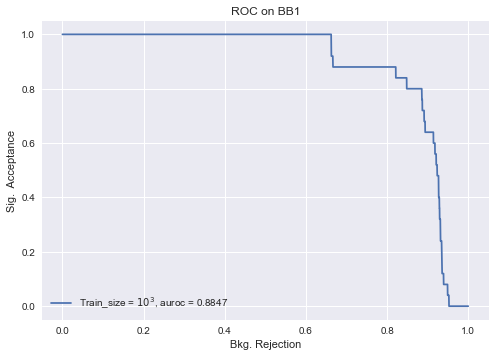

In [21]:
plt.title('ROC on BB1')
plt.style.use("seaborn")
plt.xlabel('Bkg. Rejection')
plt.ylabel('Sig.  Acceptance')
# k = 3
# for y in fid:
#     y_pred = [1 - i.tolist() for i in y]
#     fpr, tpr, thresholds = roc_curve(event_class, y_pred)
#     bkg_rejec = 1 - fpr
    
#     plt.plot(bkg_rejec, tpr, label='Train_size = $10^{%d}$' % k)
#     k += 1

y_pred = [-1 * i.tolist() for i in fid]
fpr, tpr, thresholds = roc_curve(event_class, y_pred)
bkg_rejec = 1 - fpr
auroc = roc_auc_score(event_class, y_pred)
print(auroc)
plt.plot(bkg_rejec, tpr, label='Train_size = $10^{%d}$, auroc = %.04f' % (3, auroc))
plt.legend()

In [27]:
print(type(auroc.item()))

<class 'float'>
